In [1]:
import tomotopy as tp
import numpy as np
import pandas as pd
import re
import os
import time
import itertools
import konlpy
from kiwipiepy import Kiwi
from hanspell import spell_checker
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyLDAvis


In [2]:
df=pd.read_csv('leisure2.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})
df.info()

C:\Users\jenny\AppData\Local\Temp/ipykernel_23796/1705503032.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.read_csv('leisure2.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12029 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    12029 non-null  int64 
 1   real_date     12029 non-null  object
 2   year          12029 non-null  int64 
 3   month         12029 non-null  int64 
 4   type          10567 non-null  object
 5   review_title  12029 non-null  object
 6   review        12029 non-null  object
 7   score         12029 non-null  object
 8   dataset       11869 non-null  object
dtypes: int64(3), object(6)
memory usage: 845.9+ KB


In [3]:
df['type'].unique()

array([' 커플', ' 개인', ' 가족', ' 친구', ' 비지니스', nan], dtype=object)

In [4]:
for i in range(len(df)):
    if df.iloc[i,4] in [' 친구',' 가족',' 커플']:
        df.iloc[i,4] = 'no_solo'
    elif df.iloc[i,4] in [' 비지니스', np.NaN]:
        df.iloc[i,4] = np.NaN
    elif df.iloc[i,4] in [' 개인']:
        df.iloc[i,4]='solo'

In [5]:
df['type'].unique()

array(['no_solo', 'solo', nan], dtype=object)

In [6]:
df.dropna(subset=['type'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9962 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    9962 non-null   int64 
 1   real_date     9962 non-null   object
 2   year          9962 non-null   int64 
 3   month         9962 non-null   int64 
 4   type          9962 non-null   object
 5   review_title  9962 non-null   object
 6   review        9962 non-null   object
 7   score         9962 non-null   object
 8   dataset       9816 non-null   object
dtypes: int64(3), object(6)
memory usage: 778.3+ KB


In [7]:
df[df['dataset'].isnull()]

,Unnamed: 0,real_date,year,month,type,review_title,review,score,dataset
140,140,2015년 4월,2015,4,no_solo,경복궁 을 4월 2015,"전반적으로, 이 잘 유지되는 거리. 당신이 주변의 길 이 쉽게, 심지어는 표지판이 ...",4,NaN
146,146,2015년 4월,2015,4,no_solo,다른 관광지를 방문하는 데 pecfectly; 경복궁과 창덕궁,나와 내 가족은 매우 즐거운 방문입니다. 제가 한국에서 몇 년 전에 강한 느낌을 받...,5,NaN
523,523,2015년 9월,2015,9,solo,많은 메모리가 아닌 넓은 남아 있는,제가 처음에 이: 광화문. 이 그림같은 풍경을 사진도 가능합니다 도 두 섬을 가장 ...,4,NaN
527,527,2015년 9월,2015,9,no_solo,아름다운 궁전,부모님과 저는 한 달이 지난 수요일에 팰리스 입장료는 제도가! 우리는 전통적인 음악...,4,NaN
619,619,2015년 10월,2015,10,no_solo,아름다운 고대 궁전,"저희가 마지막 달의 하루는 수요일 지정된 배양물, 입구에 팰리스가 무료였습니다. 가...",5,NaN
...,...,...,...,...,...,...,...,...,...
11615,11616,2016년 7월,2016,7,no_solo,한국에 좋은 역사적인 소개,나는 친구와 함께 하는 시크릿 가든 투어 (1.5 시간 투어) 의 관점이 되는 만족...,4,NaN
11714,11715,2016년 10월,2016,10,no_solo,멋진 도시에 와,"저는, 서울을 방문하는 많은 복잡함. 궁전의 정원이 되었지만 여전히 바빴지만 및 방...",4,NaN
11756,11757,2016년 11월,2016,11,solo,잊을 수 없는 유네스코 문화 유산!,근처에 살고 있고. 저는 말 그대로 침대에 영어 가이드 투어를 잡기 위해 10:30...,5,NaN
11918,11919,2017년 6월,2017,6,no_solo,아름다운 정원,"저희 창덕궁 으로 시간이 10:30 인데 영어 투어, 투어 를 찾는 실제로 시작 1...",5,NaN


In [9]:
df.dropna(subset=['dataset'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9816 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    9816 non-null   int64 
 1   real_date     9816 non-null   object
 2   year          9816 non-null   int64 
 3   month         9816 non-null   int64 
 4   type          9816 non-null   object
 5   review_title  9816 non-null   object
 6   review        9816 non-null   object
 7   score         9816 non-null   object
 8   dataset       9816 non-null   object
dtypes: int64(3), object(6)
memory usage: 766.9+ KB


In [10]:
#솔로/비솔로 데이터 구분
#솔로
condition = (df.type=='solo')
condition2 = (df.type=='no_solo')
df2=df.loc[condition]
df3=df.loc[condition2]

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 1 to 12021
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1688 non-null   int64 
 1   real_date     1688 non-null   object
 2   year          1688 non-null   int64 
 3   month         1688 non-null   int64 
 4   type          1688 non-null   object
 5   review_title  1688 non-null   object
 6   review        1688 non-null   object
 7   score         1688 non-null   object
 8   dataset       1688 non-null   object
dtypes: int64(3), object(6)
memory usage: 131.9+ KB


In [12]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8128 entries, 0 to 12028
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    8128 non-null   int64 
 1   real_date     8128 non-null   object
 2   year          8128 non-null   int64 
 3   month         8128 non-null   int64 
 4   type          8128 non-null   object
 5   review_title  8128 non-null   object
 6   review        8128 non-null   object
 7   score         8128 non-null   object
 8   dataset       8128 non-null   object
dtypes: int64(3), object(6)
memory usage: 635.0+ KB


In [18]:
#응집도 계산 전 사용할 토크나이저 함수 정의

import konlpy
stop_list=['우리','함께','있습니다']
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if not pos == 'Josa' and not pos =='Punctuation' and not pos =='Foreign' and len(word) > 1 and word not in stop_list :
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words

In [19]:
#솔로 데이터 토큰화
tokenized_list_solo = []
a=df2['dataset'].values
for text in range(len(a)):
    tokenized_list_solo.append(tokenize_korean_text(a[text]))

In [21]:
#솔로
model = tp.DMRModel(k=20, alpha=0.1, eta=0.01, min_cf=3,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_solo


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass
        
               
model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 

Total docs: 1688
Total words: 41988
Vocab size: 2359


In [22]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 1688 docs, 41988 words
| Total Vocabs: 7623, Used Vocabs: 2359
| Entropy of words: 6.84261
| Entropy of term-weighted words: 7.28192
| Removed Vocabs: 있는 좋은 서울
| Metadata of docs and its distribution
|  3: 168
|  4: 636
|  5: 854
|  2: 22
|  1: 8
|
<Training Info>
| Iterations: 0, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -10.08597
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal dist

==== Coherence : c ====
Average: 0.42700867812614896 
Per Topic: [0.4615932986140251, 0.36756374314427376, 0.5368980795145035, 0.4165474556386471, 0.3723480775952339, 0.45614446736872194, 0.41167745580896736, 0.4499083623290062, 0.4479780778288841, 0.40513886976987123, 0.4171529829502106, 0.4035955771803856, 0.5248313412070275, 0.47075253427028657, 0.44830817058682443, 0.39494068212807176, 0.3839835859835148, 0.41416634768247607, 0.3992722764611244, 0.3573721764609218]


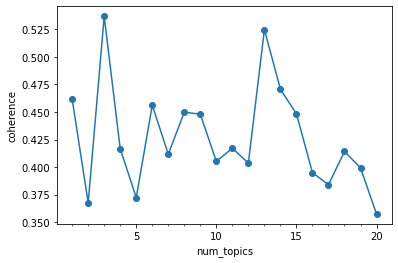

In [23]:
# calculate coherence using preset
ax=plt.axes()
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence : c ====')
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
x=range(1,21,1)
plt.plot(x, coherence_per_topic,marker='o')
plt.xlabel("num_topics")
plt.ylabel("coherence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()
print()

위 결과에서 14개일 때 가장 높은 응집도를 보였기 때문에 토픽을 14개로 설정하였다.

In [24]:
#토픽수 정하고 솔로 분석
model = tp.DMRModel(k=3, alpha=0.1, eta=0.01, min_cf=3,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_solo

for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass

model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
 
 
for i in range(200):
    model.train(1)
    
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Total docs: 1688
Total words: 41988
Vocab size: 2359
Topic #0	타워, 전망, 케이블카, 남산, 타고, 버스, 야경, 풍경, 날씨, 공원
Topic #1	궁전, 방문, 아름다운, 시간, 투어, 건물, 많은, 한국, 매우, 역사
Topic #2	산책, 하기, 경복궁, 공원, 한강, 따라, 도심, 사람, 마을, 청계천


In [25]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 1688 docs, 41988 words
| Total Vocabs: 7623, Used Vocabs: 2359
| Entropy of words: 6.84261
| Entropy of term-weighted words: 7.28192
| Removed Vocabs: 있는 좋은 서울
| Metadata of docs and its distribution
|  3: 168
|  4: 636
|  5: 854
|  2: 22
|  1: 8
|
<Training Info>
| Iterations: 200, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.33256
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 3 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal dist

In [27]:
#솔로 감성점수 계산
print('Topic distributions by score, solo')

df4=pd.DataFrame()
score_labels=['1','2','3','4','5']

for i in score_labels:
    df4[i+'score']=model.get_topic_prior(i)
df4['total']=df4.sum(axis=1)

total_sum=df4['total'].values
gamsung_sum=0
gamsung_list=[]

for i in range(model.k):
    a=df4.iloc[i,:-1].values
    gamsung_sum=(a[0]*1+a[1]*2+a[2]*3+a[3]*4+a[4]*5)/total_sum[i]
    gamsung_list.append(gamsung_sum)
    
df4['re_score']=gamsung_list
df4.head(20)

Topic distributions by score, solo


,1score,2score,3score,4score,5score,total,re_score
0,0.171504,0.433543,0.032783,0.862764,0.578069,2.078665,3.597668
1,0.290104,0.596495,1.099329,1.269812,1.510450,4.766190,3.653354
2,0.436066,0.474469,0.677536,0.792799,1.170697,3.551568,3.503325


In [28]:
#각 토픽 별 상위 10개 단어 추출
word_list=[]
for i in range(model.k):
    a=model.get_topic_words(i, top_n=10)
    word_list.append([x[0] for x in a])

df4['word_list']=word_list
df4.head(15)

,1score,2score,3score,4score,5score,total,re_score,word_list
0,0.171504,0.433543,0.032783,0.862764,0.578069,2.078665,3.597668,"[타워, 전망, 케이블카, 남산, 타고, 버스, 야경, 풍경, 날씨, 공원]"
1,0.290104,0.596495,1.099329,1.269812,1.510450,4.766190,3.653354,"[궁전, 방문, 아름다운, 시간, 투어, 건물, 많은, 한국, 매우, 역사]"
2,0.436066,0.474469,0.677536,0.792799,1.170697,3.551568,3.503325,"[산책, 하기, 경복궁, 공원, 한강, 따라, 도심, 사람, 마을, 청계천]"


In [29]:
 # extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=5, min_df=5, max_len=5, max_cand=10000, normalized=True)
cands = extractor.extract(model)

labeler = tp.label.FoRelevance(model, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(model.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 또한 케이블카, 서울, 타고 남산, 케이블카 버스, 도쿄 타워
타워	0.022271892055869102
전망	0.013449208810925484
케이블카	0.010338171385228634
남산	0.009565996937453747
타고	0.008482079952955246
버스	0.007644549012184143
야경	0.006913421675562859
풍경	0.005875733681023121
날씨	0.0058233244344592094
공원	0.005626367870718241

== Topic #1 ==
Labels: 궁전, 투어, 팰리스, 정원, 모든
궁전	0.008761907927691936
방문	0.008735915645956993
아름다운	0.008292045444250107
시간	0.007897763513028622
투어	0.007827041670680046
건물	0.0072908783331513405
많은	0.00721737602725625
한국	0.007063992787152529
매우	0.00697909714654088
역사	0.006903072353452444

== Topic #2 ==
Labels: 있는, 하는, 서울, 좋은, 사람
산책	0.009976087138056755
하기	0.007647277321666479
경복궁	0.007251487113535404
공원	0.006964303087443113
한강	0.006923125125467777
따라	0.00635170191526413
도심	0.006003353279083967
사람	0.005762598942965269
마을	0.005557687021791935
청계천	0.005424582399427891



In [31]:
#빈도 구하기 전
df5=pd.DataFrame()
df5['docs']=tokenized_list_solo
df5['score']=df2['score'].values
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docs    1688 non-null   object
 1   score   1688 non-null   object
dtypes: object(2)
memory usage: 26.5+ KB


In [32]:
#빈도 구하기

topic_num=[]
temp1=[] #토픽번호
temp2=[] #분포율
for i in range(len(model.docs)):
    a=model.docs[i].get_topics()
    temp1.append([x[0] for x in a])
    temp2.append([x[1] for x in a])
for i in range(len(temp1)):
    if temp2[i][0] >= 0.5:
        topic_num.append(temp1[i][0])
    else :
        topic_num.append(np.NaN)
df5['topic_num']=topic_num
df5[df5['topic_num'].isnull()]

,docs,score,topic_num
0,"[가면, 좋아요, 오픈, 하는, 한정, 티켓, 구매, 해서, 다녀왔었습니다, 운치,...",3,NaN
31,"[상징, 서울, 있는, 고궁, 방문, 중이, 특별히, 추천, 해드립니다, 방문, 발...",5,NaN
42,"[아름다운, 고궁, 경복궁, 한국인, 깊은, 의미, 지닌, 고궁, 입니다, 아름다운...",5,NaN
65,"[서울, 왔다면, 방문, 해야, 서울, 방문, 했다면, 봐야, 최근, 보수, 해서,...",5,NaN
69,"[아름다운, 방문, 팰리스, gyeongbokguang, 이는, 8월, 특별한, 이...",4,NaN
...,...,...,...
1676,"[관광, 한국, 이씨조선, 궁궐, 로서, 경복궁, 창덕궁, 있음, 창덕궁, 돌담, ...",4,NaN
1681,"[원형, 그대로, 조선, 경복궁, 비해, 전쟁, 인한, 파손, 별로, 없어서, 많이...",5,NaN
1684,"[창덕궁, 달빛, 기행, 프로그램, 예약, 진행, 프로그램, 유네스코, 세계, 문화...",5,NaN
1685,"[사계절, 가보고, 싶은, 11월, 아버지, 후원, 관람, 했습니다, 늦가을, 단풍...",5,NaN


In [38]:
df6=df5.groupby(['topic_num','score'])['docs']
print(df6.size().reset_index(name='counts'))

    topic_num score  counts
0         0.0     2       6
1         0.0     3      19
2         0.0     4     102
3         0.0     5      86
4         1.0     1       3
5         1.0     2       8
6         1.0     3      74
7         1.0     4     252
8         1.0     5     388
9         2.0     1       4
10        2.0     2       6
11        2.0     3      38
12        2.0     4     125
13        2.0     5     183
